In [1]:
import os
from dotenv import load_dotenv
from openai import OpenAI
import google.generativeai as genai
import anthropic
import gradio as gr

In [2]:
# Load environment variables in a file called .env

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "your-key-if-not-using-env")
os.environ["ANTHROPIC_API_KEY"] = os.getenv(
    "ANTHROPIC_API_KEY", "your-key-if-not-using-env"
)
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY", "your-key-if-not-using-env")

In [3]:
system_message = "You are a helpful assistant that analyzes the content of an article and provides a summary in markdown."
prompt = "Please provide a short summary of the article in markdown format."

In [4]:
# Connect to OpenAI, Anthropic and Google

openai = OpenAI()

claude = anthropic.Anthropic()

genai.configure()

In [5]:
# Let's wrap a call to GPT-4o-mini in a simple function

def summarize_gpt(prompt=prompt):
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": prompt},
    ]
    response = openai.chat.completions.create(
        model="gpt-4o-mini", messages=messages, stream=False
    )
    return response.choices[0].message.content

In [6]:
def summarize_claude(article_text):
    """
    Sends an article to the Anthropic API to generate a summary.
    
    Parameters:
    article_text (str): The full text of the article to be summarized.
    
    Returns:
    str: The summary of the article generated by the Anthropic API.
    """
    
    system_message = """
    You are an AI assistant tasked with summarizing articles. Your goal is to provide a concise, accurate, and informative summary of the key points in the given article text. Focus on capturing the main ideas, key findings, and important conclusions. Avoid including unnecessary details or tangents. The summary should be approximately 1-2 paragraphs in length.
    """
    
    try:
        response = claude.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=1000,
            system = system_message,
            messages = [
                {"role": "user", "content": article_text}
            ]
        )
        return response.content[0].text
    except Exception as e:
        raise Exception(f"Error summarizing article: {e}")

In [7]:
def gemini(prompt=prompt):
    gemini = genai.GenerativeModel(
    model_name='gemini-1.5-flash',
    system_instruction=system_message
    )
    response = gemini.generate_content(prompt)
    return response.candidates[0].content.parts[0].text

In [8]:
import pandas as pd

# Read a sample article from a CSV file
df = pd.read_csv("articles.csv")
df.head()

,article_id,full_text,ABSTRACT
0,PMC11315657,Exploring the association between melatonin an...,Due to the addictive qualities of tobacco prod...
1,PMC11204383,Antibodies Against ZSCAN1 in Pediatric and Adu...,"Objectives, To report the association of zinc ..."
2,PMC11301388,Gingival mesenchymal stem cells: Biological pr...,Our understanding of mesenchymal stem cells (M...
3,PMC11240861,Research progress of DNA methylation in colore...,DNA methylation is one of the earliest and mos...
4,PMC11289611,"Investigating the Relationship of Serum CD163,...","Objective, This study aimed to compare serum l..."


In [9]:
# Select the first article
article = df["full_text"][0]
abstract = df["ABSTRACT"][0]

In [10]:
openai_response = summarize_gpt(article)
print(openai_response)

# Summary of "Exploring the Association Between Melatonin and Nicotine Dependence"

## Introduction
- **Nicotine Dependence**: A significant global public health challenge marked by compulsive cravings and physiological dependence on nicotine, leading to various health issues, including cardiovascular diseases, respiratory disorders, and cancer.
- **Melatonin**: A neuroendocrine hormone primarily synthesized by the pineal gland, known for regulating circadian rhythms and exhibiting antioxidant and neuroprotective properties.
- Recent studies suggest a potential link between melatonin and nicotine dependence, with melatonin receptors dispersed throughout the brain, particularly in areas related to reward pathways.

## Physiological Roles of Melatonin
- **Circadian Rhythms**: Melatonin helps regulate sleep-wake cycles, with its production influenced by light exposure.
- **Antioxidant Properties**: Melatonin protects cells from oxidative damage and enhances antioxidant enzyme activity.
- 

In [11]:
# Use the Anthropic API to summarize the article
anthropic_response = summarize_claude(article)
print(anthropic_response)

Here is a summary of the key points from the article:

The article explores the potential association between the neuroendocrine hormone melatonin and nicotine dependence. Nicotine dependence is a major public health challenge, as it contributes to numerous adverse health consequences like cardiovascular disease, respiratory disorders, and cancer. 

Melatonin, often called the "hormone of darkness," plays a crucial role in regulating circadian rhythms and has diverse physiological functions beyond sleep regulation, including antioxidant, immunomodulatory, and neuroprotective properties. Melatonin receptors are widely distributed throughout the brain, including regions involved in the reward pathway and addiction-related behaviors.

Preclinical studies suggest that melatonin may modulate the reinforcing effects of nicotine and attenuate nicotine-seeking behavior by influencing neurotransmitter systems like dopamine, glutamate, GABA, and serotonin. Melatonin may also help mitigate nicoti

In [12]:
# Use the Google Generative AI API to summarize the article
gemini_response = gemini(article)
print(gemini_response)

## Melatonin and Nicotine Dependence: A Comprehensive Review

This review explores the potential association between melatonin and nicotine dependence. The authors delve into the mechanisms of both nicotine dependence and melatonin's diverse physiological roles, highlighting their potential interplay.

**Nicotine Dependence:**

* **Mechanisms:** Nicotine's addictive qualities stem from its ability to activate the brain's reward pathways, particularly the mesolimbic dopaminergic system, leading to pleasure and reinforcement of addictive behavior.
* **Health consequences:** Nicotine dependence contributes to a myriad of acute and chronic medical conditions, including cardiovascular disease, respiratory disorders, and cancer.

**Melatonin:**

* **Physiological roles:** Primarily synthesized nocturnally by the pineal gland, melatonin plays a crucial role in regulating circadian rhythms, exhibits potent antioxidant properties, modulates the immune system, and exerts neuroprotective effects.

In [13]:
import evaluate

In [14]:
rouge = evaluate.load("rouge")

# Evaluate the summaries generated by the different models
openai_scores = rouge.compute(predictions=[openai_response], references=[abstract])
print("OpenAI gemini-1.5-flash Scores:")
print(openai_scores)

OpenAI gemini-1.5-flash Scores:
{'rouge1': 0.5057142857142857, 'rouge2': 0.12893982808022922, 'rougeL': 0.24000000000000002, 'rougeLsum': 0.3342857142857143}


In [15]:
anthropic_scores = rouge.compute(predictions=[anthropic_response], references=[abstract])
print("Anthropic Scores:")
print(anthropic_scores)

Anthropic Scores:
{'rouge1': 0.53515625, 'rouge2': 0.20392156862745098, 'rougeL': 0.27734375, 'rougeLsum': 0.30859375000000006}


In [16]:
genai_scores = rouge.compute(predictions=[gemini_response], references=[abstract])
print("Google Generative AI Scores:")
print(genai_scores)

Google Generative AI Scores:
{'rouge1': 0.5284810126582278, 'rouge2': 0.19365079365079363, 'rougeL': 0.2626582278481013, 'rougeLsum': 0.36392405063291144}


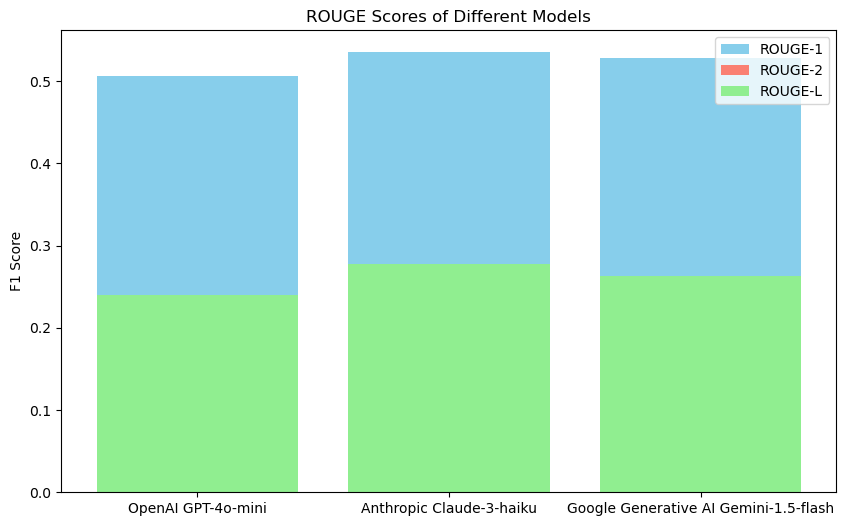

In [17]:
# Create a chart to compare the ROUGE scores of the different models

import matplotlib.pyplot as plt

models = ["OpenAI GPT-4o-mini", "Anthropic Claude-3-haiku", "Google Generative AI Gemini-1.5-flash"]

rouge_1_scores = [openai_scores["rouge1"], anthropic_scores["rouge1"], genai_scores["rouge1"]]
rouge_2_scores = [openai_scores["rouge2"], anthropic_scores["rouge2"], genai_scores["rouge2"]]
rouge_l_scores = [openai_scores["rougeL"], anthropic_scores["rougeL"], genai_scores["rougeL"]]

plt.figure(figsize=(10, 6))
plt.bar(models, rouge_1_scores, color="skyblue", label="ROUGE-1")
plt.bar(models, rouge_2_scores, color="salmon", label="ROUGE-2")
plt.bar(models, rouge_l_scores, color="lightgreen", label="ROUGE-L")
plt.ylabel("F1 Score")
plt.title("ROUGE Scores of Different Models")
plt.legend()
plt.show()

In [25]:
# Create a Gradio interface to summarize articles using the different models

def summarize_article(prompt, model):
    if model == "GPT":
        return summarize_gpt(prompt)
    elif model == "Claude":
        return summarize_claude(prompt)
    elif model == "Gemini":
        return gemini(prompt)

In [31]:
view = gr.Interface(
    fn=summarize_article,
    inputs=[
        gr.Textbox(label="Your article:"),
        gr.Dropdown(["GPT", "Claude", "Gemini"], label="Select model", value="GPT"),
    ],
    outputs=[gr.Markdown(label="Summary")],
    flagging_mode="never",
    description="Summarize an article using different models.",
)

view.launch(share=True)

* Running on local URL:  http://127.0.0.1:7869

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2024/11/11 13:36:07 [W] [service.go:132] login to server failed: session shutdown


## To do: Fine-tuning LLM for our use case